Acknowledgement: This code was initially inspired by the lab "COMP34212_Lab2b_Keras_CNN_CIFAR_2025" before undergoing significant changes.

# Setup

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras import utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, SpatialDropout2D
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Input, Add
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import backend as K


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

print('Libraries imported.')

Libraries imported.


# Data Preperation

In [ ]:



cifar100_fine_labels = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

cifar100_coarse_labels = [
    'aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables',
    'household electrical devices', 'household furniture', 'insects', 'large carnivores',
    'large man-made outdoor things', 'large natural outdoor scenes', 'large omnivores and herbivores',
    'medium-sized mammals', 'non-insect invertebrates', 'people', 'reptiles', 'small mammals',
    'trees', 'vehicles 1', 'vehicles 2'
]


fine_to_coarse_mapping = {
    0: 4, 1: 1, 2: 14, 3: 8, 4: 0, 5: 6, 6: 7, 7: 7,
    8: 18, 9: 3, 10: 3, 11: 14, 12: 9, 13: 18, 14: 7, 15: 11,
    16: 3, 17: 9, 18: 7, 19: 11, 20: 6, 21: 11, 22: 5, 23: 10,
    24: 7, 25: 6, 26: 13, 27: 15, 28: 3, 29: 15, 30: 0, 31: 11,
    32: 1, 33: 10, 34: 12, 35: 14, 36: 16, 37: 9, 38: 11, 39: 5,
    40: 5, 41: 19, 42: 8, 43: 8, 44: 15, 45: 13, 46: 14, 47: 17,
    48: 18, 49: 10, 50: 16, 51: 4, 52: 17, 53: 4, 54: 2, 55: 0,
    56: 17, 57: 4, 58: 18, 59: 17, 60: 10, 61: 3, 62: 2, 63: 12,
    64: 12, 65: 16, 66: 12, 67: 1, 68: 9, 69: 19, 70: 2, 71: 10,
    72: 0, 73: 1, 74: 16, 75: 12, 76: 9, 77: 13, 78: 15, 79: 13,
    80: 16, 81: 18, 82: 2, 83: 4, 84: 6, 85: 19, 86: 5, 87: 5,
    88: 8, 89: 19, 90: 18, 91: 1, 92: 2, 93: 15, 94: 6, 95: 0,
    96: 17, 97: 8, 98: 14, 99: 13
}

In [ ]:

BATCH_SIZE = 256
N_EPOCH = 50
N_CLASSES = 100
N_SUPERCLASSES = 20
VERBOSE = 1
VALIDATION_SPLIT = 0.2

print('Main variables initialised.')


IMG_CHANNELS = 3
IMG_ROWS = 32
IMG_COLS = 32

print('Image variables initialisation')


Main variables initialised.
Image variables initialisation


In [ ]:

(input_X_train, output_y_train), (input_X_test, output_y_test) = cifar100.load_data(label_mode='fine')
print('input_X_train shape:', input_X_train.shape)
print(input_X_train.shape[0], 'train samples')
print(input_X_test.shape[0], 'test samples')


output_Y_train = utils.to_categorical(output_y_train, N_CLASSES)
output_Y_test = utils.to_categorical(output_y_test, N_CLASSES)


input_X_train = input_X_train.astype('float32')
input_X_test = input_X_test.astype('float32')
input_X_train /= 255
input_X_test /= 255


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
input_X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


Sample input image class: apple


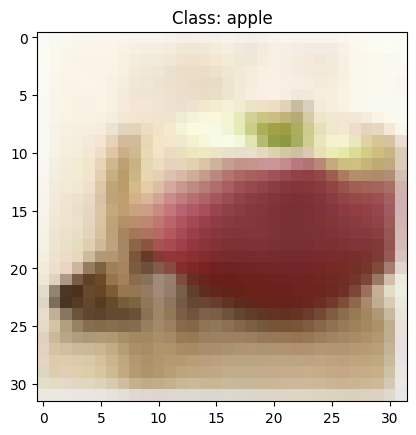

Sample input image class: boy


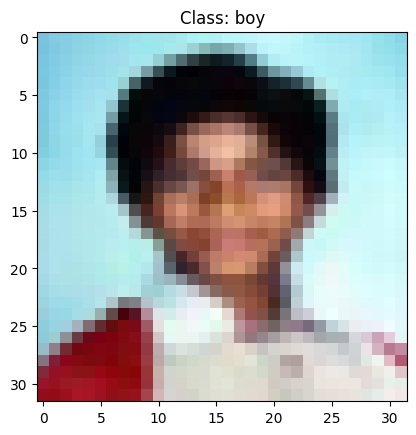

In [ ]:

Selected_Image = 2
image = input_X_train[Selected_Image]
print("Sample input image class:", cifar100_fine_labels[output_y_train[Selected_Image][0]])
plt.imshow(image)
plt.title(f"Class: {cifar100_fine_labels[output_y_train[Selected_Image][0]]}")
plt.show()

Selected_Image = 3
image = input_X_train[Selected_Image]
print("Sample input image class:", cifar100_fine_labels[output_y_train[Selected_Image][0]])
plt.imshow(image)
plt.title(f"Class: {cifar100_fine_labels[output_y_train[Selected_Image][0]]}")
plt.show()

# Training

In [ ]:
def identity_block(x, filters):
    x_skip = x


    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)


    x = Add()([x, x_skip])
    x = Activation('relu')(x)
    return x


In [ ]:
def conv_block(x, filters, stride):
    x_skip = x


    x = Conv2D(filters, 3, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)


    x_skip = Conv2D(filters, 1, strides=stride, padding='same')(x_skip)
    x_skip = BatchNormalization()(x_skip)

    x = Add()([x, x_skip])
    x = Activation('relu')(x)
    return x


In [ ]:

inputs = Input(shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS))


x = Conv2D(64, 3, strides=1, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)




x = conv_block(x, 64, stride=1)
x = identity_block(x, 64)


x = conv_block(x, 128, stride=2)
x = identity_block(x, 128)


x = conv_block(x, 256, stride=2)
x = identity_block(x, 256)


x = GlobalAveragePooling2D()(x)
outputs = Dense(N_CLASSES, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
class TrainingMonitor(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = K.get_value(self.model.optimizer.learning_rate)
        print(f"\nEpoch {epoch+1}")
        print(f"LR: {lr:.1e}\n")
        print(f"  Training Loss: {logs['loss']:.4f} - Training Accuracy: {logs['accuracy']:.4f}")
        print(f"  Validation Loss: {logs['val_loss']:.4f} - Validation Accuracy: {logs['val_accuracy']:.4f}")
        if logs['accuracy'] - logs['val_accuracy'] > 0.15:
            print(f"! Overfitting: {logs['accuracy']-logs['val_accuracy']:.4f} gap")



In [ ]:

OPTIM1 = RMSprop()
model.compile(loss='categorical_crossentropy', optimizer=OPTIM1, metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 64)     │          4,160 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 32, 32, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 32, 32, 64)     │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)    

 Total params: 2,811,940 (10.73 MB)

 Trainable params: 2,807,332 (10.71 MB)

 Non-trainable params: 4,608 (18.00 KB)

In [ ]:

early_stop = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=8,
    restore_best_weights=True,
    start_from_epoch=10
)

In [ ]:

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
history = model.fit(
    input_X_train, output_Y_train,
    batch_size=BATCH_SIZE,
    epochs=N_EPOCH,
    validation_split=VALIDATION_SPLIT,
    verbose=VERBOSE,
    callbacks=[
        early_stop,
        checkpoint,
        TrainingMonitor(),
    ]
)


Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.0715 - loss: 4.2170
Epoch 1: val_accuracy improved from -inf to 0.00840, saving model to best_model.h5



Epoch 1
LR: 1.0e-03

  Training Loss: 3.8561 - Training Accuracy: 0.1122
  Validation Loss: 15.3851 - Validation Accuracy: 0.0084
157/157 ━━━━━━━━━━━━━━━━━━━━ 37s 108ms/step - accuracy: 0.0718 - loss: 4.2147 - val_accuracy: 0.0084 - val_loss: 15.3851
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2064 - loss: 3.2242
Epoch 2: val_accuracy improved from 0.00840 to 0.05540, saving model to best_model.h5



Epoch 2
LR: 1.0e-03

  Training Loss: 3.0723 - Training Accuracy: 0.2368
  Validation Loss: 4.8909 - Validation Accuracy: 0.0554
! Overfitting: 0.1814 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.2066 - loss: 3.2232 - val_accuracy: 0.0554 - val_loss: 4.8909
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3046 - loss: 2.6807
Epoch 3: val_accuracy did not improve from 0.05540

Epoch 3
LR: 1.0e-03

  Training Loss: 2.5755 - Training Accuracy: 0.3288
  Validation Loss: 6.5209 - Validation Accuracy: 0.0534
! Overfitting: 0.2754 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.3048 - loss: 2.6801 - val_accuracy: 0.0534 - val_loss: 6.5209
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3966 - loss: 2.2850
Epoch 4: val_accuracy improved from 0.05540 to 0.19690, saving model to best_model.h5



Epoch 4
LR: 1.0e-03

  Training Loss: 2.2132 - Training Accuracy: 0.4092
  Validation Loss: 3.8995 - Validation Accuracy: 0.1969
! Overfitting: 0.2123 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.3966 - loss: 2.2846 - val_accuracy: 0.1969 - val_loss: 3.8995
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4606 - loss: 1.9819
Epoch 5: val_accuracy did not improve from 0.19690

Epoch 5
LR: 1.0e-03

  Training Loss: 1.9475 - Training Accuracy: 0.4656
  Validation Loss: 5.2799 - Validation Accuracy: 0.1699
! Overfitting: 0.2957 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.4607 - loss: 1.9816 - val_accuracy: 0.1699 - val_loss: 5.2799
Epoch 6/50
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5189 - loss: 1.7405
Epoch 6: val_accuracy improved from 0.19690 to 0.29590, saving model to best_model.h5



Epoch 6
LR: 1.0e-03

  Training Loss: 1.7254 - Training Accuracy: 0.5201
  Validation Loss: 3.1761 - Validation Accuracy: 0.2959
! Overfitting: 0.2242 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5189 - loss: 1.7403 - val_accuracy: 0.2959 - val_loss: 3.1761
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5661 - loss: 1.5456
Epoch 7: val_accuracy did not improve from 0.29590

Epoch 7
LR: 1.0e-03

  Training Loss: 1.5423 - Training Accuracy: 0.5646
  Validation Loss: 3.9765 - Validation Accuracy: 0.2440
! Overfitting: 0.3206 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5661 - loss: 1.5456 - val_accuracy: 0.2440 - val_loss: 3.9765
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6074 - loss: 1.3783
Epoch 8: val_accuracy improved from 0.29590 to 0.30140, saving model to best_model.h5



Epoch 8
LR: 1.0e-03

  Training Loss: 1.3722 - Training Accuracy: 0.6072
  Validation Loss: 3.3355 - Validation Accuracy: 0.3014
! Overfitting: 0.3058 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6074 - loss: 1.3782 - val_accuracy: 0.3014 - val_loss: 3.3355
Epoch 9/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6562 - loss: 1.1904
Epoch 9: val_accuracy did not improve from 0.30140

Epoch 9
LR: 1.0e-03

  Training Loss: 1.2113 - Training Accuracy: 0.6489
  Validation Loss: 3.7149 - Validation Accuracy: 0.2638
! Overfitting: 0.3851 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6562 - loss: 1.1905 - val_accuracy: 0.2638 - val_loss: 3.7149
Epoch 10/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6929 - loss: 1.0472
Epoch 10: val_accuracy did not improve from 0.30140

Epoch 10
LR: 1.0e-03

  Training Loss: 1.0619 - Training Accuracy: 0.6886
  Validation Loss: 4.4638 - Validation Accuracy: 0.2235
! Overfitting: 0.4651 gap
157/157 ━━━━━━━━━


Epoch 12
LR: 1.0e-03

  Training Loss: 0.7740 - Training Accuracy: 0.7698
  Validation Loss: 2.8391 - Validation Accuracy: 0.3593
! Overfitting: 0.4105 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7758 - loss: 0.7693 - val_accuracy: 0.3593 - val_loss: 2.8391
Epoch 13/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8197 - loss: 0.6135
Epoch 13: val_accuracy did not improve from 0.35930

Epoch 13
LR: 1.0e-03

  Training Loss: 0.6368 - Training Accuracy: 0.8084
  Validation Loss: 3.5115 - Validation Accuracy: 0.3565
! Overfitting: 0.4519 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8196 - loss: 0.6137 - val_accuracy: 0.3565 - val_loss: 3.5115
Epoch 14/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8562 - loss: 0.4928
Epoch 14: val_accuracy did not improve from 0.35930

Epoch 14
LR: 1.0e-03

  Training Loss: 0.5123 - Training Accuracy: 0.8454
  Validation Loss: 3.7565 - Validation Accuracy: 0.3411
! Overfitting: 0.5043 gap
157/157 ━━━━━


Epoch 16
LR: 1.0e-03

  Training Loss: 0.3123 - Training Accuracy: 0.9097
  Validation Loss: 3.0969 - Validation Accuracy: 0.4066
! Overfitting: 0.5031 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9178 - loss: 0.2959 - val_accuracy: 0.4066 - val_loss: 3.0969
Epoch 17/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9344 - loss: 0.2353
Epoch 17: val_accuracy did not improve from 0.40660

Epoch 17
LR: 1.0e-03

  Training Loss: 0.2499 - Training Accuracy: 0.9283
  Validation Loss: 4.2375 - Validation Accuracy: 0.3273
! Overfitting: 0.6010 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9344 - loss: 0.2354 - val_accuracy: 0.3273 - val_loss: 4.2375
Epoch 18/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9495 - loss: 0.1858
Epoch 18: val_accuracy did not improve from 0.40660

Epoch 18
LR: 1.0e-03

  Training Loss: 0.1969 - Training Accuracy: 0.9453
  Validation Loss: 3.7980 - Validation Accuracy: 0.3585
! Overfitting: 0.5868 gap
157/157 ━━━━━


Epoch 20
LR: 1.0e-03

  Training Loss: 0.1345 - Training Accuracy: 0.9637
  Validation Loss: 3.3960 - Validation Accuracy: 0.4098
! Overfitting: 0.5539 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9654 - loss: 0.1318 - val_accuracy: 0.4098 - val_loss: 3.3960
Epoch 21/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9727 - loss: 0.1090
Epoch 21: val_accuracy did not improve from 0.40980

Epoch 21
LR: 1.0e-03

  Training Loss: 0.1199 - Training Accuracy: 0.9685
  Validation Loss: 4.7081 - Validation Accuracy: 0.3519
! Overfitting: 0.6166 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9726 - loss: 0.1091 - val_accuracy: 0.3519 - val_loss: 4.7081
Epoch 22/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9728 - loss: 0.1002
Epoch 22: val_accuracy improved from 0.40980 to 0.44480, saving model to best_model.h5



Epoch 22
LR: 1.0e-03

  Training Loss: 0.1080 - Training Accuracy: 0.9704
  Validation Loss: 3.7283 - Validation Accuracy: 0.4448
! Overfitting: 0.5256 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9728 - loss: 0.1002 - val_accuracy: 0.4448 - val_loss: 3.7283
Epoch 23/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9806 - loss: 0.0776
Epoch 23: val_accuracy did not improve from 0.44480

Epoch 23
LR: 1.0e-03

  Training Loss: 0.0903 - Training Accuracy: 0.9764
  Validation Loss: 4.1886 - Validation Accuracy: 0.3914
! Overfitting: 0.5850 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9806 - loss: 0.0777 - val_accuracy: 0.3914 - val_loss: 4.1886
Epoch 24/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9828 - loss: 0.0680
Epoch 24: val_accuracy did not improve from 0.44480

Epoch 24
LR: 1.0e-03

  Training Loss: 0.0782 - Training Accuracy: 0.9793
  Validation Loss: 4.2287 - Validation Accuracy: 0.3783
! Overfitting: 0.6010 gap
157/157 ━━━━━

In [ ]:

predictions = model.predict(input_X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(output_Y_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


## Evaluation

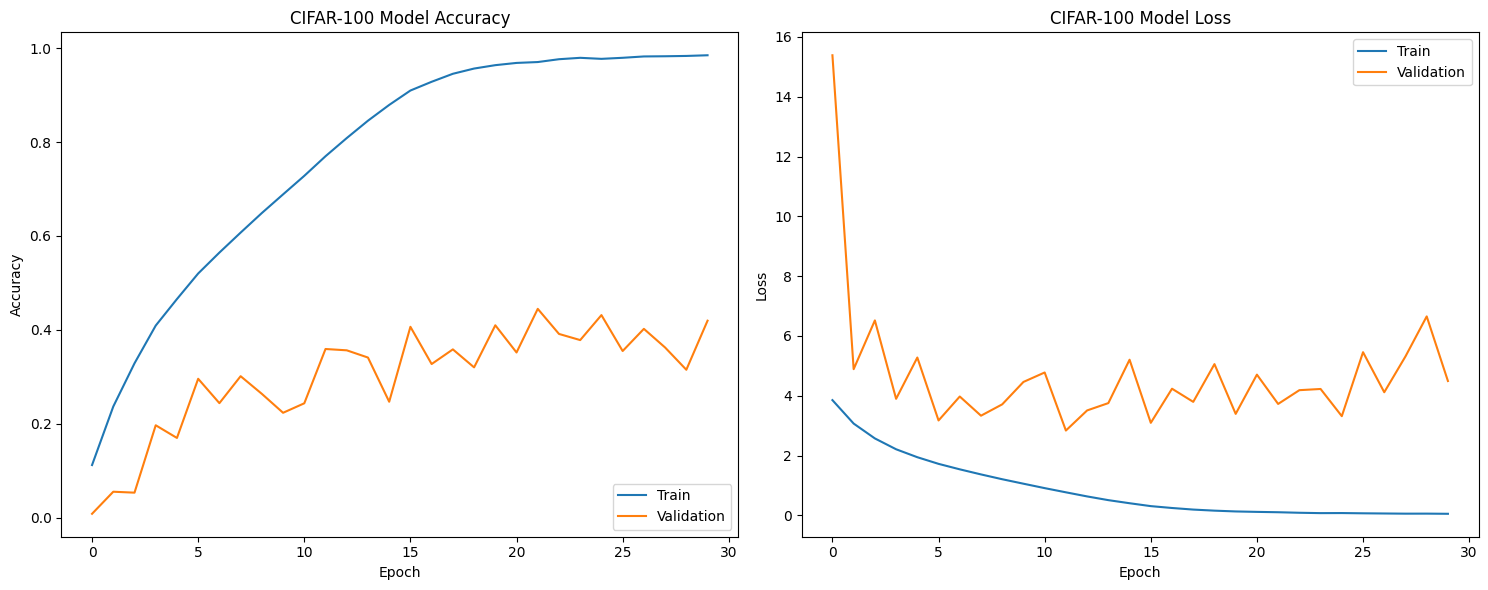

In [ ]:


plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CIFAR-100 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CIFAR-100 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:


test_loss, test_accuracy = model.evaluate(input_X_test, output_Y_test, verbose=VERBOSE)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


superclass_y_true = np.array([fine_to_coarse_mapping[y] for y in y_true])
superclass_y_pred = np.array([fine_to_coarse_mapping[y] for y in y_pred])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4595 - loss: 3.7291

Test Loss: 3.7484
Test Accuracy: 0.4517
